In [1]:
%pylab inline
import numpy as np
import torch

from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.autograd import Variable
from torch.utils.data import dataloader

from torchvision import transforms
from torchvision.datasets import MNIST

from sklearn.metrics import accuracy_score

from graphviz import Digraph

Populating the interactive namespace from numpy and matplotlib


## Configuration

In [2]:
BATCH_SIZE = 32

## Data (MNIST)

In [3]:
train = MNIST('./data', train=True, download=True, transform=transforms.Compose([
    transforms.ToTensor(), # ToTensor does min-max normalization. 
]), )

test = MNIST('./data', train=False, download=True, transform=transforms.Compose([
    transforms.ToTensor(), # ToTensor does min-max normalization. 
    
]), )

# Create DataLoader
dataloader_args = dict(shuffle=True, batch_size=BATCH_SIZE ,num_workers=1, pin_memory=True)
train_loader = dataloader.DataLoader(train, **dataloader_args)
test_loader = dataloader.DataLoader(test, **dataloader_args)

Processing...
Done!


In [23]:
dataloader_args

{'batch_size': 32, 'num_workers': 1, 'pin_memory': True, 'shuffle': True}

In [24]:
train_loader

## Model Discriminator

### Discriminator

* $ x_i \sim P_{\rm data} $ (즉 true data distribution) 에서 왔다면 1
* $ x_i = G(z) $ 이때 $ z \sim p_{\rm generator} $ (generators' distribution)에서 왔다면 0

즉 Discriminator는 "이 사진이 진짜냐? (가짜가 아니고)" 라고 질문하는 것

In [4]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.fc1 = nn.Linear(784, 441)
        self.fc2 = nn.Linear(441, 256)
        self.fc3 = nn.Linear(256, 32)
        self.fc4 = nn.Linear(32, 1)
        
        self.bc1 = nn.BatchNorm1d(441)
        self.bc2 = nn.BatchNorm1d(256)
                
    def forward(self, x):
        x = x.view((-1, 784))
        h = self.fc1(x)
#         h = self.bc1(h)
        h = F.leaky_relu(h)
        h = F.dropout(h, p=0.2, training=self.training)
        
        h = self.fc2(h)
#         h = self.bc2(h)
        h = F.leaky_relu(h)
        h = F.dropout(h, p=0.2, training=self.training)
        
        h = self.fc3(h)
        h = F.leaky_relu(h)
        
        h = self.fc4(h)
        out = F.sigmoid(h)
        return out

D = Discriminator()
print(D.cuda()) # CUDA!
d_optimizer = optim.Adam(D.parameters(), lr=0.001)

Discriminator(
  (fc1): Linear(in_features=784, out_features=441, bias=True)
  (fc2): Linear(in_features=441, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
  (bc1): BatchNorm1d(441, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bc2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


### Generator

In [5]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        self.fc1 = nn.Linear(100, 196)
        self.fc2 = nn.Linear(196, 289)
        self.fc3 = nn.Linear(289, 361)
        self.fc4 = nn.Linear(361, 400)
        self.fc5 = nn.Linear(400, 512)
        self.fc6 = nn.Linear(512, 625)
        self.fc7 = nn.Linear(625, 784)
        self.fc8 = nn.Linear(784, 784)
        
        self.bc1 = nn.BatchNorm1d(196)
        self.bc2 = nn.BatchNorm1d(289)
        self.bc3 = nn.BatchNorm1d(361)
        self.bc4 = nn.BatchNorm1d(400)
        self.bc5 = nn.BatchNorm1d(512)
        self.bc6 = nn.BatchNorm1d(625)
        self.bc7 = nn.BatchNorm1d(784)
    
    def forward(self, x):
        h = self.fc1(x)
        h = self.bc1(h)
        h = F.leaky_relu(h)
        h = F.dropout(h, p=0.5, training=self.training)
        
        h = self.fc2(h)
        h = self.bc2(h)
        h = F.leaky_relu(h)
        h = F.dropout(h, p=0.5, training=self.training)
        
        h = self.fc3(h)
        h = self.bc3(h)
        h = F.leaky_relu(h)
        h = F.dropout(h, p=0.5, training=self.training)
        
        h = self.fc4(h)
        h = self.bc4(h)
        h = F.leaky_relu(h)
        h = F.dropout(h, p=0.4, training=self.training)
        
        h = self.fc5(h)
        h = self.bc5(h)
        h = F.leaky_relu(h)
        h = F.dropout(h, p=0.4, training=self.training)
        
        h = self.fc6(h)
        h = self.bc6(h)
        h = F.leaky_relu(h)
        h = F.dropout(h, p=0.4, training=self.training)
        
        h = self.fc7(h)
        h = self.bc7(h)
        h = F.leaky_relu(h)
        h = F.dropout(h, p=0.4, training=self.training)
        
        h = self.fc8(h)
        out = F.sigmoid(h)
        return out

G = Generator()
print(G.cuda())
g_optimizer = optim.Adam(G.parameters(), lr=0.001)


Generator(
  (fc1): Linear(in_features=100, out_features=196, bias=True)
  (fc2): Linear(in_features=196, out_features=289, bias=True)
  (fc3): Linear(in_features=289, out_features=361, bias=True)
  (fc4): Linear(in_features=361, out_features=400, bias=True)
  (fc5): Linear(in_features=400, out_features=512, bias=True)
  (fc6): Linear(in_features=512, out_features=625, bias=True)
  (fc7): Linear(in_features=625, out_features=784, bias=True)
  (fc8): Linear(in_features=784, out_features=784, bias=True)
  (bc1): BatchNorm1d(196, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bc2): BatchNorm1d(289, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bc3): BatchNorm1d(361, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bc4): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bc5): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bc6): BatchNorm1d(625, eps=1e-05, moment

## Model Visualization

In [6]:
def make_dot(var):
    node_attr = dict(style='filled',
                     shape='box',
                     align='left',
                     fontsize='12',
                     ranksep='0.1',
                     height='0.2')
    dot = Digraph(node_attr=node_attr, graph_attr=dict(size="12,12"))
    seen = set()

    def add_nodes(var):
        if var not in seen:
            if isinstance(var, Variable):
                value = '('+(', ').join(['%d'% v for v in var.size()])+')'
                dot.node(str(id(var)), str(value), fillcolor='lightblue')
            else:
                dot.node(str(id(var)), str(type(var).__name__))
            seen.add(var)
            if hasattr(var, 'previous_functions'):
                for u in var.previous_functions:
                    dot.edge(str(id(u[0])), str(id(var)))
                    add_nodes(u[0])
    add_nodes(var.grad_fn)
    return dot

### Discriminator for Real Images

In [7]:
real_image = train[0][0].cuda()
real_image = Variable(real_image)
make_dot(D(real_image))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


### Discriminator for Fake Images

In [8]:
fake_distributions = Variable(torch.randn((BATCH_SIZE, 100)).cuda())
images = G(fake_distributions)
make_dot(images)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


## Train

* $ 1 $ : real images
* $ 0 $ : fake images

In [16]:
N_EPOCH = 10

real_y = Variable(torch.ones((BATCH_SIZE, 1)).cuda())
fake_y = Variable(torch.zeros((BATCH_SIZE, 1)).cuda())
loss_f = nn.BCELoss()

d_real_losses = list()
d_fake_losses = list()
d_losses = list()
g_losses = list()
divergences = list()

In [17]:
# Train Discriminator with Generator not being trained
# 먼저 Discriminator를 학습시킵니다.
# 이때 real image와 fake이미지 두개의 데이터를 사용하여 학습합니다. 
# Discriminator를 학습시킬때는 Generator는 학습시키면 안됩니다.
for epoch in range(N_EPOCH):
    for step, (real_images, _) in enumerate(train_loader):
        # Samples
        real_images = Variable(real_images.cuda())
        z = Variable(torch.randn((BATCH_SIZE, 100)).cuda())
                
        ###############################################
        # Train D (But do not train G)
        ###############################################
        # Init D
        d_optimizer.zero_grad()
        
        # Calculate the loss with real images
        y_real_pred = D(real_images)
        d_real_loss = loss_f(y_real_pred, real_y)
#         d_real_loss.backward()
#         d_optimizer.step()
        
        # Calculate the loss with fake images
        fake_distributions = Variable(torch.randn((BATCH_SIZE, 100)).cuda())
        fake_images = G(fake_distributions).detach()
        y_fake_pred = D(fake_images)
        d_fake_loss = loss_f(y_fake_pred, fake_y)
#         d_fake_loss.backward()
#         d_optimizer.step()
        
        # Update D with G not being updated        
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step()

        ###############################################
        # Train G with fake images but do not train G
        ###############################################
        g_optimizer.zero_grad()
        
        fake_distributions = Variable(torch.randn((BATCH_SIZE, 100)).cuda())
        fake_images = G(fake_distributions)
        y_pred = D(fake_images)
        g_loss = loss_f(y_pred, real_y)
        g_loss.backward()
        g_optimizer.step()
        
        ###############################################
        # Visualization
        ###############################################
        if step%5 == 0:
            d_real_losses.append(d_real_loss.data[0])
            d_fake_losses.append(d_fake_loss.data[0])
            d_losses.append(d_loss.data[0])
            g_losses.append(g_loss.data.cpu().numpy())

            divergences.append(torch.mean(y_real_pred/(y_real_pred+y_fake_pred)).data[0])
        
        if step % 50 == 0:
            print(f'\r[{epoch+1}/{N_EPOCH}]',
                  # '{:.3}'.format(torch.mean(params[0]).data[0]),
                  'divergence: {:<8.3}'.format(np.mean(divergences[-100:])),
                  'D: {:<8.3}'.format(np.mean(d_fake_losses[-100:])), 
                  'D_real: {:<8.3}'.format(np.mean(d_real_losses[-100:])),
                  'D_fake: {:<8.3}'.format(np.mean(d_fake_losses[-100:])), 
                  'G:{:<8.3}'.format(np.mean(g_losses[-100:])), end='')
    print()

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:57: UserWarning: invalid index of a 0-dim tensor. This will be an error in 

[1/10] divergence: 0.883    D: 0.183    D_real: 0.233    D_fake: 0.183    G:3.3     
[2/10] divergence: 0.823    D: 0.279    D_real: 0.307    D_fake: 0.279    G:2.48    
[3/10] divergence: 0.762    D: 0.348    D_real: 0.403    D_fake: 0.348    G:1.9     
[4/10] divergence: 0.753    D: 0.363    D_real: 0.41     D_fake: 0.363    G:1.82    
[5/10] divergence: 0.732    D: 0.384    D_real: 0.445    D_fake: 0.384    G:1.7     
[6/10] divergence: 0.732    D: 0.395    D_real: 0.432    D_fake: 0.395    G:1.67    
[7/10] divergence: 0.707    D: 0.44     D_real: 0.458    D_fake: 0.44     G:1.57    
[8/10] divergence: 0.704    D: 0.424    D_real: 0.467    D_fake: 0.424    G:1.54    
[9/10] divergence: 0.687    D: 0.449    D_real: 0.501    D_fake: 0.449    G:1.47    
[10/10] divergence: 0.694    D: 0.431    D_real: 0.496    D_fake: 0.431    G:1.48    


In [34]:
stop = 0
for step, (real_images, _) in enumerate(train_loader):
    # Samples
    real_images = Variable(real_images.cuda())
    z = Variable(torch.randn((BATCH_SIZE, 100)).cuda())
    stop += 1             
    if stop == 10:
        break

In [38]:
z.shape

torch.Size([32, 100])

## Loss Visualization

In [18]:
def smooth(x,window_len=100,window='hanning'):
    x = np.array(x)
    
    if x.ndim != 1:
        raise ValueError("smooth only accepts 1 dimension arrays.")

    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.")

    if window_len<3:
        return x

    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")

    s=numpy.r_[x[window_len-1:0:-1],x,x[-1:-window_len:-1]]
    
    if window == 'flat': #moving average
        w=numpy.ones(window_len,'d')
    else:
        w=eval('numpy.'+window+'(window_len)')

    y=numpy.convolve(w/w.sum(),s,mode='valid')
    return y

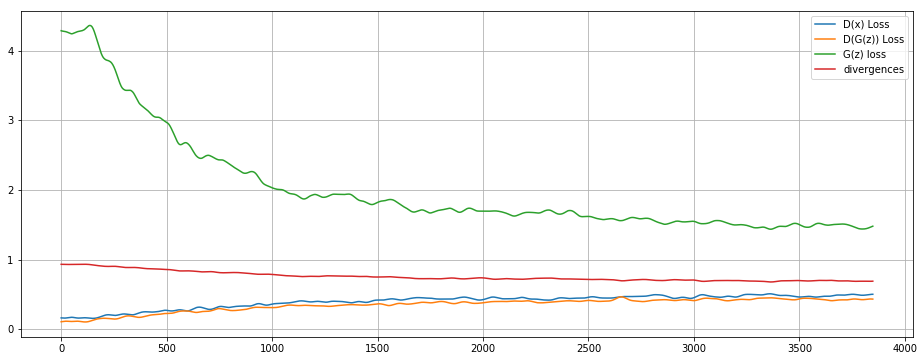

In [19]:
figsize(16, 6)
plot(smooth(d_real_losses), label='D(x) Loss')
plot(smooth(d_fake_losses), label='D(G(z)) Loss')
plot(smooth(g_losses), label='G(z) loss')
plot(smooth(divergences), label='divergences')

grid()
legend()

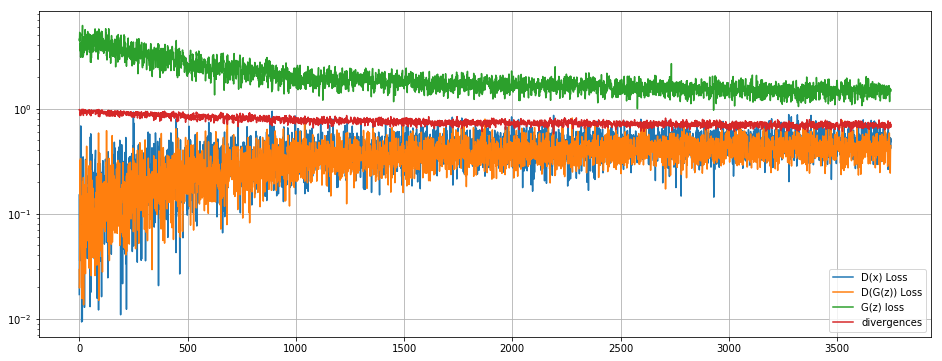

In [20]:
plot(d_real_losses, label='D(x) Loss')
plot(d_fake_losses, label='D(G(z)) Loss')
plot(g_losses, label='G(z) loss')
plot(divergences, label='divergences')

yscale('log')
grid()
legend()

# Evaluate

## Evaluate Generator

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


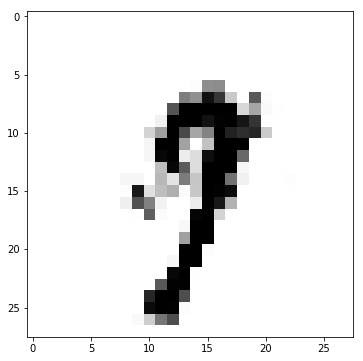

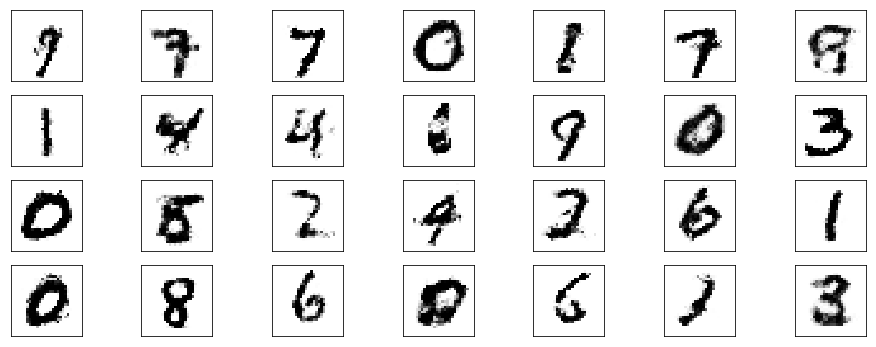

In [21]:
fake_distributions = Variable(torch.randn((BATCH_SIZE, 100)).cuda())
images = G(fake_distributions).view((-1, 28, 28)).data.cpu().numpy()

imshow(images[0], cmap=cm.gray_r)

fig, subplots = pylab.subplots(4, 7) # subplots(y축, x축 갯수)

idx = 0
for _subs in subplots:
    for subplot in _subs:
        d = images[idx]
        subplot.get_xaxis().set_visible(False)
        subplot.get_yaxis().set_visible(False)
        subplot.imshow(d, cmap=cm.gray_r)
        idx += 1


## Evaluate Discriminator

In [22]:
n_test = test_loader.dataset.test_data.size()[0]
y_test_real_labels = np.ones((n_test, 1))
y_test_fake_labels = np.zeros((n_test, 1))

# Predict Real Images
test_data = Variable(test_loader.dataset.test_data.cuda().type_as(torch.cuda.FloatTensor()))
y_test_real_pred = D(test_data)


# Predict Fake Images
fake_distributions = Variable(torch.randn((n_test, 100)).cuda())
fake_images = G(fake_distributions).detach()
y_test_fake_pred = D(fake_images)

# Evaluate
y_test_real_pred = torch.round(y_test_real_pred).data.cpu().numpy()
y_test_fake_pred = torch.round(y_test_fake_pred).data.cpu().numpy()

print('Discriminator Real Image Accuracy:', accuracy_score(y_test_real_labels, y_test_real_pred))
print('Discriminator Fake Image Accuracy:', accuracy_score(y_test_fake_labels, y_test_fake_pred))

Discriminator Real Image Accuracy: 0.9358
Discriminator Fake Image Accuracy: 0.8091


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
